In [72]:
# ==========================================
# CELL 1: SETUP & RESUME LOGIC
# ==========================================
import json
import pickle
import time
import os
import networkx as nx
import hashlib
from tqdm.notebook import tqdm
from groq import Groq
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import random
import pandas as pd
import re

load_dotenv(override=True)
client = Groq(api_key=os.environ["GROQ_API_KEY"])

# --- CONFIGURATION (CHANGE THIS MANUALLY) ---
# CURRENT_MODEL = "llama-3.3-70b-versatile" # 100k TPD
# CURRENT_MODEL = "openai/gpt-oss-120b" # 200k TPD

# CURRENT_MODEL = "moonshotai/kimi-k2-instruct" #  300k TPD - 32B
# CURRENT_MODEL = "moonshotai/kimi-k2-instruct-0905" # 300k TPD - 32B
# CURRENT_MODEL = "qwen/qwen3-32b" # 500k TPD - 32B

# CURRENT_MODEL = "openai/gpt-oss-20b" # 200k TPD 

# CURRENT_MODEL = "meta-llama/llama-4-maverick-17b-128e-instruct" # 500k TPD
CURRENT_MODEL = "meta-llama/llama-4-scout-17b-16e-instruct" # 500k TPD


# SESSION_TOKEN_LIMIT = 80_000 # llama 70b - 20k for failed chunks 
# SESSION_TOKEN_LIMIT = 180_000 # oss-120b (20k for failed chunks) and oss-20b
# SESSION_TOKEN_LIMIT = 301_000 # kimi k2 models 
SESSION_TOKEN_LIMIT = 501_000 # qwen 32b and meta models

# --- PATHS ---
GRAPH_PATH = "./models/knowledge_graph.pkl"
PROCESSED_LOG_PATH = "./models/processed_chunks.json"
CHUNKS_PATH = "./models/chunk_metadata.pkl"
FAILED_LOG_PATH = "./models/failed_chunks.json"

# --- LOAD RESOURCES ---
with open(CHUNKS_PATH, "rb") as f:
    chunks = pickle.load(f)

if os.path.exists(GRAPH_PATH):
    print(f"📂 Found existing graph at {GRAPH_PATH}. Loading...")
    with open(GRAPH_PATH, "rb") as f:
        kg = pickle.load(f)
else:
    print("🆕 No existing graph found. Creating new empty graph.")
    kg = nx.DiGraph()

if os.path.exists(PROCESSED_LOG_PATH):
    with open(PROCESSED_LOG_PATH, "r") as f:
        processed_ids = set(json.load(f))
    print(f"📝 Found log: {len(processed_ids)} chunks already processed.")
else:
    processed_ids = set()
    print("📝 No log found. Starting fresh.")

if os.path.exists(FAILED_LOG_PATH):
    with open(FAILED_LOG_PATH, "r") as f:
        failed_ids = set(json.load(f))
        print(f"❌ Found log: {len(failed_ids)} chunks failed.")
else:
    failed_ids = set()
    print("❌ No failed log found. Starting fresh.")
    
def get_chunk_id(text):
    return hashlib.md5(text.encode()).hexdigest()

print(f"✅ Setup Complete. Ready to use model: {CURRENT_MODEL}")

📂 Found existing graph at ./models/knowledge_graph.pkl. Loading...
📝 Found log: 8128 chunks already processed.
❌ Found log: 0 chunks failed.
✅ Setup Complete. Ready to use model: meta-llama/llama-4-scout-17b-16e-instruct


In [73]:
# 3. Load Processed IDs (To avoid re-doing work)
if os.path.exists(PROCESSED_LOG_PATH):
    with open(PROCESSED_LOG_PATH, "r") as f:
        processed_ids = set(json.load(f))
    print(f"📝 Found log: {len(processed_ids)} chunks already processed.")
else:
    processed_ids = set()
    print("📝 No log found. Starting fresh.")



📝 Found log: 8128 chunks already processed.


In [74]:
# ==========================================
# CELL 2: EXTRACTION ENGINE
# ==========================================
def extract_triples(text, model_name):
    """
    Returns: (list_of_triples, total_tokens_used)
    Raises exception if API fails.
    """
    system_prompt = """
    You are a Knowledge Graph extractor. 
    Task: Extract key facts from the text as Subject-Predicate-Object triples.
    
    Rules:
    1. Subject and Object must be specific entities (People, Places, Dates).
    2. Predicate should be a short verb phrase (e.g., "released", "located_in").
    3. Output MUST be valid JSON only. No markdown formatting. No preamble.
    4. Format: {"triples": [{"head": "Subject", "type": "Relation", "tail": "Object"}, ...]}
    """

    completion = client.chat.completions.create(
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": text}
        ],
        model=model_name,
        temperature=0,
        response_format={"type": "json_object"}
    )

    content = completion.choices[0].message.content
    result = json.loads(content)
    triples = result.get("triples", [])

    usage = completion.usage
    total_tokens = usage.total_tokens
    
    return triples, total_tokens

print("✅ Extractor Function.")

✅ Extractor Function.


In [ ]:
# ==========================================
# CELL 3: BUILD GRAPH 
# ==========================================
# --- CONFIGURATION ---
# TARGET_RPM = 25           # llama-70b, oss-120b, oss-20b and meta models  (30)
TARGET_RPM = 50           # kimi k2 models, qwen (60)       
SAVE_EVERY_N = 10         
SAFETY_BUFFER = 1000      # Stop if we are within 1000 tokens of the limit
FAILED_LOG_PATH = "./models/failed_chunks.json"

# Metrics
session_tokens = 0
chunks_processed_this_run = 0
request_interval = 60.0 / TARGET_RPM

print(f"🚀 STARTING EXTRACTION LOOP")
print(f"   • Model: {CURRENT_MODEL}")
print(f"   • Stop Limit: {SESSION_TOKEN_LIMIT}")
print("-" * 40)

try:
    pbar = tqdm(chunks)
    for doc in pbar:
        text = doc['text']
        c_id = get_chunk_id(text)
        
        # SKIP Logic
        if c_id in processed_ids:
            continue
            
        # STOP Logic (Soft Limit)
        if session_tokens >= (SESSION_TOKEN_LIMIT - SAFETY_BUFFER):
            print(f"🛑 SESSION LIMIT REACHED (Counter says {session_tokens}). Stopping safely.")
            break

        # RATE LIMITING
        time.sleep(request_interval)
            
        # EXTRACTION ATTEMPT
        try:
            triples, tokens = extract_triples(text, CURRENT_MODEL)
            
            # Valid Extraction Logic
            valid_count = 0
            for item in triples:
                subj = item.get('head')
                obj = item.get('tail')
                rel = item.get('type')
                if not subj or not obj or not rel: continue
                kg.add_node(subj, type="entity")
                kg.add_node(obj, type="entity")
                kg.add_edge(subj, obj, relation=rel)
                valid_count += 1
            
            # Update State
            processed_ids.add(c_id)
            session_tokens += tokens
            chunks_processed_this_run += 1
            if c_id in failed_ids: failed_ids.remove(c_id)

            pbar.set_description(f"Tok/Chunks:{session_tokens} / {chunks_processed_this_run} = {session_tokens/chunks_processed_this_run:.2f} | Nodes / Edges: {kg.number_of_nodes()} / {kg.number_of_edges()} = {kg.number_of_edges()/kg.number_of_nodes():.2f} Failed:{len(failed_ids)}")

        except Exception as e:
            error_msg = str(e)
            # --- CRITICAL: CHECK FOR RATE LIMIT ---
            if "429" in error_msg or "rate_limit_exceeded" in error_msg:
                print(f"\n🚨 ACTUAL API LIMIT HIT (429).")
                print(f"   Groq Message: {error_msg}")
                used_match = re.search(r"Used (\d+)", error_msg)
                if used_match:
                    real_usage = int(used_match.group(1))
                    print(f"   💡 Real Usage Today: {real_usage}")
                print(f"🛑 STOPPING LOOP IMMEDIATELY TO PREVENT SPAM. chunk {c_id}")
                break 
            if "json_validate_failed" in error_msg:
                print(f"⚠️ JSON Error on chunk {c_id}")
            else:
                print(f"⚠️ API Error on chunk {c_id}: {e}")
            
            failed_ids.add(c_id)
        
        # CHECKPOINT SAVE
        if chunks_processed_this_run % SAVE_EVERY_N == 0:
            with open(GRAPH_PATH, "wb") as f: pickle.dump(kg, f)
            with open(PROCESSED_LOG_PATH, "w") as f: json.dump(list(processed_ids), f)
            with open(FAILED_LOG_PATH, "w") as f: json.dump(list(failed_ids), f)

except KeyboardInterrupt:
    print("\n👋 User interrupted.")

# --- FINAL SAVE ---
print("\n💾 Saving Final State...")
with open(GRAPH_PATH, "wb") as f: pickle.dump(kg, f)
with open(PROCESSED_LOG_PATH, "w") as f: json.dump(list(processed_ids), f)
with open(FAILED_LOG_PATH, "w") as f: json.dump(list(failed_ids), f)

print("-" * 40)
print("✅ RUN PAUSED/COMPLETED")
print(f"   • Chunks Processed This Run: {chunks_processed_this_run}")
print(f"   • Total Chunks Processed: {len(processed_ids)}")
print(f"   • Total Chunks Failed: {failed_ids}")
print("-" * 40)


🚀 STARTING EXTRACTION LOOP
   • Model: meta-llama/llama-4-scout-17b-16e-instruct
   • Stop Limit: 501000
----------------------------------------


  0%|          | 0/39141 [00:00<?, ?it/s]

📊 KNOWLEDGE GRAPH STATISTICS
🔹 Total Nodes (Entities):   72,286
🔹 Total Edges (Relations):  78,722
🔹 Graph Density:            0.00002 (Higher = more interconnected)
🔹 Avg Connections per Node: 1.09

🏆 TOP 5 MOST CONNECTED ENTITIES
   1. Nanjing (770 connections)
   2. Arnold Schwarzenegger (686 connections)
   3. Beyoncé (585 connections)
   4. New York City (521 connections)
   5. Boston (414 connections)

🔗 TOP 5 RELATIONSHIP TYPES
located_in    3419
includes       691
part_of        504
is             364
released       347

🎨 Visualizing top 100 nodes...


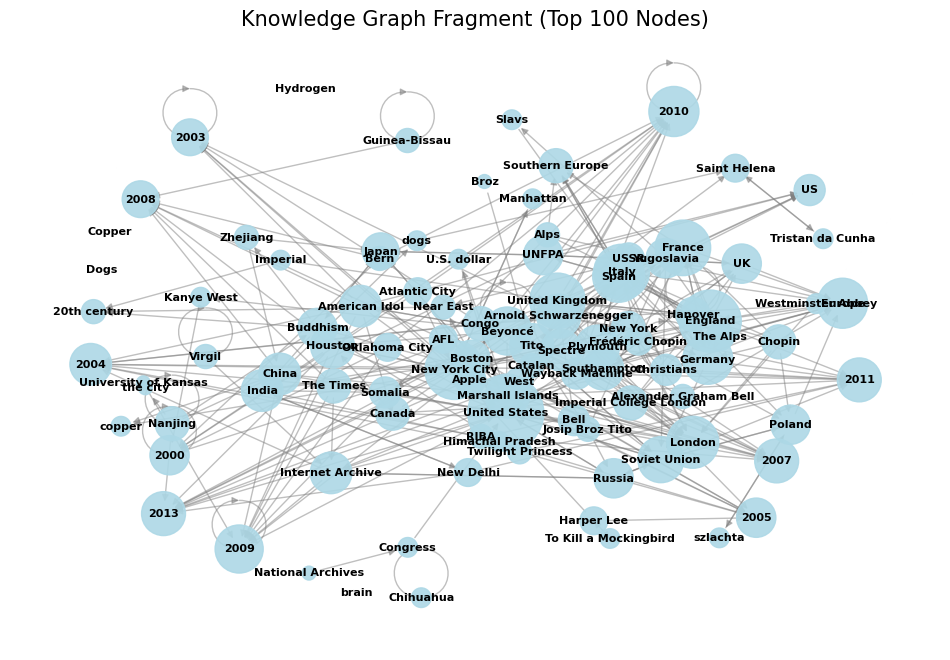

In [ ]:
# ==========================================
# CELL 4: GRAPH ANALYTICS & VISUALIZATION
# ==========================================
def analyze_and_visualize(G, viz_limit=50):
    if G.number_of_nodes() == 0:
        print("⚠️ Graph is empty. Run Cell 3 to extract data first!")
        return

    # --- PART 1: NUMERIC STATISTICS ---
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)
    
    # Calculate degrees (connections)
    degrees = dict(G.degree())
    sorted_nodes = sorted(degrees.items(), key=lambda item: item[1], reverse=True)
    
    # Top 5 "Central" Nodes (Most mentioned entities)
    top_5 = sorted_nodes[:5]
    
    # Analyze Relations (Predicates)
    # We extract all edge attributes to see what kind of relationships we found
    all_relations = [d['relation'] for u, v, d in G.edges(data=True)]
    relation_counts = pd.Series(all_relations).value_counts().head(5)

    print(f"📊 KNOWLEDGE GRAPH STATISTICS")
    print(f"==============================")
    print(f"🔹 Total Nodes (Entities):   {num_nodes:,}")
    print(f"🔹 Total Edges (Relations):  {num_edges:,}")
    print(f"🔹 Graph Density:            {density:.5f} (Higher = more interconnected)")
    print(f"🔹 Avg Connections per Node: {num_edges / num_nodes:.2f}")
    print(f"\n🏆 TOP 5 MOST CONNECTED ENTITIES")
    for i, (node, count) in enumerate(top_5, 1):
        print(f"   {i}. {node} ({count} connections)")
        
    print(f"\n🔗 TOP 5 RELATIONSHIP TYPES")
    print(relation_counts.to_string())
    print(f"==============================\n")

    # --- PART 2: VISUALIZATION ---
    print(f"🎨 Visualizing top {viz_limit} nodes...")
    plt.figure(figsize=(12, 8))
    
    # Subgraph of top nodes only
    top_node_names = [n[0] for n in sorted_nodes[:viz_limit]]
    subgraph = G.subgraph(top_node_names)
    
    # Layout (Spring layout tends to push connected nodes together)
    # k=0.5 controls the distance between nodes
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)
    
    # Draw Nodes
    # Size depends on degree (more connections = bigger circle)
    node_sizes = [subgraph.degree(n) * 100 for n in subgraph.nodes()]
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='lightblue', alpha=0.9)
    
    # Draw Edges
    nx.draw_networkx_edges(subgraph, pos, edge_color='gray', alpha=0.5, arrows=True)
    
    # Draw Labels
    nx.draw_networkx_labels(subgraph, pos, font_size=8, font_weight="bold")
    
    # Draw Edge Labels (Relations) - Only if not too cluttered
    if viz_limit <= 30:
        edge_labels = nx.get_edge_attributes(subgraph, 'relation')
        nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=6)
    
    plt.title(f"Knowledge Graph Fragment (Top {viz_limit} Nodes)", fontsize=15)
    plt.axis('off') # Hide axis numbers
    plt.show()

# Run the Analysis
analyze_and_visualize(kg, viz_limit=100)

In [35]:
# ==========================================
# DUPLICATE DETECTOR
# ==========================================
import hashlib
from collections import defaultdict

# 1. Group chunks by their ID
id_map = defaultdict(list)

print("🕵️‍♂️ Scanning for duplicates...")
for i, doc in enumerate(chunks):
    text = doc['text']
    c_id = hashlib.md5(text.encode()).hexdigest()
    id_map[c_id].append(i)

# 2. Find IDs that appear more than once
duplicates = {k: v for k, v in id_map.items() if len(v) > 1}

print(f"📊 Analysis Complete:")
print(f"   • Total Chunks: {len(chunks)}")
print(f"   • Unique IDs:   {len(id_map)}")
print(f"   • Duplicate IDs found: {len(duplicates)}")

if len(duplicates) > 0:
    print("\n🔍 Example of a Duplicate:")
    sample_id = list(duplicates.keys())[0]
    indices = duplicates[sample_id]
    print(f"   ID: {sample_id} appears at indices {indices}")
    print(f"   Text 1: {chunks[indices[0]]['text'][:50]}...")
    print(f"   Text 2: {chunks[indices[1]]['text'][:50]}...")
    
    if chunks[indices[0]]['text'] == chunks[indices[1]]['text']:
        print("\n✅ CONFIRMED: The text is identical.")
    else:
        print("\n⚠️ WARNING: Actual Hash Collision! (This would be historic news)")

🕵️‍♂️ Scanning for duplicates...
📊 Analysis Complete:
   • Total Chunks: 39141
   • Unique IDs:   39088
   • Duplicate IDs found: 52

🔍 Example of a Duplicate:
   ID: 1596784390e2ee56b4f90496418b3f6b appears at indices [274, 305]
   Text 1: . Laird writes that Tibetans eagerly sought Ming c...
   Text 2: . Laird writes that Tibetans eagerly sought Ming c...

✅ CONFIRMED: The text is identical.


In [36]:
# ==========================================
# CELL 6: RETRY FAILED CHUNKS (THE CLEANUP)
# ==========================================
# --- CONFIGURATION ---
# Use your "Smartest" model here.
RETRY_MODEL = "llama-3.3-70b-versatile" 
# RETRY_MODEL = "openai/gpt-oss-120b" 

TARGET_RPM = 25            # Slower, safer speed for the retry
SAVE_EVERY_N = 5           # Save more frequently
FAILED_LOG_PATH = "./models/failed_chunks.json"

# SAFETY LIMIT FOR RETRY SESSION
# Set this based on the chosen model's remaining quota
SESSION_TOKEN_LIMIT = 10_000 

# --- LOAD RESOURCES ---
# 1. Load the Failed List
if os.path.exists(FAILED_LOG_PATH):
    with open(FAILED_LOG_PATH, "r") as f:
        failed_ids = set(json.load(f))
else:
    print("✅ No failed chunks found! You are good to go.")
    failed_ids = set()

# 2. Load the Graph
with open(GRAPH_PATH, "rb") as f:
    kg = pickle.load(f)

# 3. Load Processed Log (to update it when we succeed)
with open(PROCESSED_LOG_PATH, "r") as f:
    processed_ids = set(json.load(f))

# 4. Identify the actual chunk objects that need retrying
retry_queue = [c for c in chunks if get_chunk_id(c['text']) in failed_ids]

print(f"🧹 STARTING CLEANUP with {RETRY_MODEL}")
print(f"   • Failed Chunks to Retry: {len(retry_queue)}")
print(f"   • Session Token Limit: {SESSION_TOKEN_LIMIT}")
print("-" * 40)

# --- RETRY LOOP ---
retry_tokens = 0
fixed_count = 0
request_interval = 60.0 / TARGET_RPM

if len(retry_queue) > 0:
    try:
        pbar = tqdm(retry_queue)
        for doc in pbar:
            text = doc['text']
            c_id = get_chunk_id(text)
            
            # --- 1. SAFETY STOP CHECK ---
            if retry_tokens >= SESSION_TOKEN_LIMIT:
                print(f"🛑 SESSION LIMIT REACHED ({retry_tokens} tokens). Stopping safely.")
                break
            
            # Rate Limit
            time.sleep(request_interval)
            
            try:
                # 2. Attempt Extraction with SMART Model
                triples, tokens = extract_triples(text, RETRY_MODEL)
                
                # 3. Validate & Update Graph
                valid_triples = 0
                for item in triples:
                    subj = item.get('head')
                    obj = item.get('tail')
                    rel = item.get('type')
                    
                    if not subj or not obj or not rel:
                        continue
                        
                    kg.add_node(subj, type="entity")
                    kg.add_node(obj, type="entity")
                    kg.add_edge(subj, obj, relation=rel)
                    valid_triples += 1
                
                # 4. Success! Update Logs
                if valid_triples > 0: 
                    processed_ids.add(c_id)     # Mark as Done
                    failed_ids.remove(c_id)     # Remove from Failed
                    retry_tokens += tokens
                    fixed_count += 1
                else:
                    # If model returned valid JSON but empty triples, we still pay the tokens
                    retry_tokens += tokens
                
                pbar.set_description(f"Tok: {session_tokens} | Nodes: {kg.number_of_nodes()} | Edges: {kg.number_of_edges()} | Chunks: {chunks_processed_this_run} | Failed: {len(failed_ids)}")
                
            except Exception as e:
                print(f"❌ Retry Failed for {c_id[:6]}: {e}")
                # We simply leave it in 'failed_ids' to try again another day
            
            # 5. Checkpoint Save (Update all files)
            if fixed_count % SAVE_EVERY_N == 0:
                with open(GRAPH_PATH, "wb") as f:
                    pickle.dump(kg, f)
                with open(PROCESSED_LOG_PATH, "w") as f:
                    json.dump(list(processed_ids), f)
                with open(FAILED_LOG_PATH, "w") as f:
                    json.dump(list(failed_ids), f)

    except KeyboardInterrupt:
        print("\n👋 Cleanup interrupted manually.")

    # --- FINAL SAVE ---
    print("\n💾 Saving Cleanup Results...")
    with open(GRAPH_PATH, "wb") as f:
        pickle.dump(kg, f)
    with open(PROCESSED_LOG_PATH, "w") as f:
        json.dump(list(processed_ids), f)
    with open(FAILED_LOG_PATH, "w") as f:
        print(list(failed_ids))
        json.dump(list(failed_ids), f)

    print("-" * 40)
    print("✨ CLEANUP SESSION ENDED")
    print(f"   • Chunks Fixed: {fixed_count}")
    print(f"   • Remaining Failures: {len(failed_ids)}")
    print(f"   • Tokens Used: {retry_tokens}")
    
else:
    print("🎉 Nothing to retry!")

🧹 STARTING CLEANUP with llama-3.3-70b-versatile
   • Failed Chunks to Retry: 0
   • Session Token Limit: 10000
----------------------------------------
🎉 Nothing to retry!
